# Walkthough of Vamb from the Python interpreter

The Vamb pipeline consist of a series of tasks each which have a dedicated module:

1) Parse fasta file and get TNF of each sequence, as well as sequence length and names (module `parsecontigs`)

2) Parse the BAM files and get abundance estimate for each sequence in the fasta file (module `parsebam`)

3) Train a VAE witthe depths and TNF matrices, and encode it to a latent representation (module `encode`)

4) Cluster the encoded inputs to metagenomic bins (modules `threshold` and `cluster`)

Additionally, for developing and testing Vamb, we use:

5) Benchmark the resulting bins against a gold standard using `benchmark`

In the following chapters of this walkthrough, we will go through each step in more detail from within the Python interpreter. We will first show how to use Vamb by example, then explain what each step does, some of the theory behind the actions, and the different parameters that can be set. With this knowledge, you should be able to extend or alter the behaviour of Vamb more easily.

For the examples, we will assume the following relevant prerequisite files exists in the directory `/home/jakni/Downloads/example/`:

* `contigs.fna` - The filtered FASTA contigs which were mapped against, and
* `bamfiles/*.bam` - The 6 .bam files from mapping the reads to the contigs above.

## Table of contents:

### 1. [Importing Vamb and getting help](#importing)

### 2. [Parse the FASTA file](#parsecontigs)

### 3. [Parse the BAM files](#parsebam)

### 4. [Train the autoencoder and encode input data](#encode)

### 5. [Binning the encoding](#cluster)

### 6. [Summary of full workflow](#summary)

### 7. [Optional: Benchmarking your bins](#benchmark)

<a id="importing"></a>
## Importing Vamb and getting help

First step is to get Vamb imported
    
    [jakni@nissen:~]$ python
    >>> import vamb
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
    ModuleNotFoundError: No module named 'vamb'
    
We're not in the directory containing the vamb directory. That means the directory containing the vamb directory is not in your sys.path. We need to either move the vamb directory to one of your sys.path dirs or add the directory containing the vamb directory to sys.path. We'll do the latter.
    
    [jakni@nissen:~]$ python
    >>> import sys
    >>> sys.path.append('/home/jakni/Documents/scripts/')
    >>> import vamb

Now we got it imported. When using Vamb, you'll almost certianly need help (we wish it was so easy you didn't, but making user friendly software is *hard!*).

Luckily, there's the built-in `help` function in Python.

---

`>>> help(vamb)`
    
    Help on package vamb:

    NAME
        vamb - Variational Autoencoder for Metagenomic Binning

    DESCRIPTION
        Vamb does what it says on the tin - bins metagenomes using a variational autoencoder.
        
    [ lines elided ]
    
        General workflow:
        1) Filter contigs by size using vamb.vambtools.filtercontigs
        2) Map reads to contigs to obtain BAM file
        3) Calculate TNF of contigs using vamb.parsecontigs
        4) Create RPKM table using vamb.parsebam
        5) Train autoencoder using vamb.encode
        6) Cluster latent representation using vamb.cluster
    
    [ lines elided ]
    
---
    
The `PACKAGE CONTENTS` under `help(vamb)` is just a list of all *importable* files in the `vamb` directory - some of these aren't part of the Vamb package proper and really shouldn't be imported, so ignore that.

---
You can also get help for each of the modules, for example the `cluster` module:

`>>> help(vamb.cluster)`

    Help on module vamb.cluster in vamb:

    NAME
        vamb.cluster - Iterative medoid clustering.

    DESCRIPTION
        Usage:
        >>> cluster_iterator = cluster(rpkms, tnfs, labels=contignames)
        >>> clusters = dict(cluster_iterator)

        Implements two core functions: cluster and tandemcluster, along with the helper
        functions writeclusters and readclusters.
        For all functions in this module, a collection of clusters are represented as
        a {clustername, set(elements)} dict.

        cluster algorithm:
    
    [ lines elided ]
        
---
And for functions:

`>>> help(vamb.cluster.tandemcluster)`

    Help on function cluster in module vamb.cluster:

    cluster(matrix, labels=None, inner=None, outer=None, max_steps=15, normalized=False, nsamples=2000, maxsize=2500, logfile=None)
        Iterative medoid cluster generator. Yields (medoid), set(labels) pairs.

        Inputs:
            matrix: A (obs x features) Numpy matrix of values
            labels: None or Numpy array with labels for matrix rows [None = ints]
            inner: Optimal medoid search within this distance from medoid [None = auto]
            outer: Radius of clusters extracted from medoid. [None = inner]
            max_steps: Stop searching for optimal medoid after N futile attempts [15]
            normalized: Matrix is already zscore-normalized [False]
            nsamples: Estimate threshold from N samples [1000]
            maxsize: Discard sample if more than N contigs are within threshold [2500]
            logfile: Print threshold estimates and certainty to file [None]

        Output: Generator of (medoid, set(labels_in_cluster)) tuples.

---

In [19]:
import sys
sys.path.append('/home/jakni/Documents/scripts/')
import vamb

<a id="parsecontigs"></a>
## Parse the FASTA file

If you forget what to do at each step, remember that `help(vamb)` said:

    General workflow:
    1) Filter contigs by size using vamb.vambtools.filtercontigs
    2) Map reads to contigs to obtain BAM file
    3) Calculate TNF of contigs using vamb.parsecontigs
    
    [ lines elided ]

Okay, we already have filtered contigs. I could have used the vamb.vambtools.filtercontigs to filter the FASTA file, but here, they were already filtered. We have also already mapped reads to them and gotten BAM files, so we begin with the third step, using the `vamb.parsecontigs` module. How do you use that?

In [20]:
help(vamb.parsecontigs)

Help on module vamb.parsecontigs in vamb:

NAME
    vamb.parsecontigs - Calculate z-normalized tetranucleotide frequency from a FASTA file.

DESCRIPTION
    Usage:
    >>> with open('/path/to/contigs.fna', 'rb') as filehandle
    ...     tnfs, contignames, lengths = read_contigs(filehandle)

FUNCTIONS
    read_contigs(byte_iterator, minlength=100)
        Parses a FASTA file open in binary reading mode.
        
        Input:
            byte_iterator: Iterator of binary lines of a FASTA file
            minlength[100]: Ignore any references shorter than N bases 
        
        Outputs:
            tnfs: A (n_FASTA_entries x 136) matrix of tetranucleotide freq.
            contignames: A lNumpy array of contig headers
            lengths: A Numpy array of contig lengths

FILE
    /home/jakni/Documents/scripts/vamb/parsecontigs.py




---
I use `vamb.parsecontigs.read_contigs` with the inputs and outputs as written:

---

In [21]:
# File must be opened in binary mode
with open('/home/jakni/Downloads/example/contigs.fna', 'rb') as filehandle:
    tnfs, contignames, lengths = vamb.parsecontigs.read_contigs(filehandle)

---
Let's have a look at the resulting data

---

In [4]:
print('Type of tnfs:', type(tnfs), 'of dtype', tnfs.dtype)
print('Shape of tnfs:', tnfs.shape, end='\n\n')

print('Type of contignames:', type(contignames), 'of dtype', contignames.dtype)
print('Length of contignames:', len(contignames), end='\n\n')

print('First 5 elements of contignames:')
for i in range(5):
    print(contignames[i])

print('\nType of lengths:', type(lengths), 'of dtype', lengths.dtype)
print('Length of lengths:', len(lengths), end='\n\n')

print('First 5 elements of lengths:')
for i in range(5):
    print(lengths[i])

Type of tnfs: <class 'numpy.ndarray'> of dtype float32
Shape of tnfs: (39551, 136)

Type of contignames: <class 'numpy.ndarray'> of dtype <U39
Length of contignames: 39551

First 5 elements of contignames:
s30_NODE_1_length_245508_cov_18.4904
s30_NODE_2_length_222690_cov_39.7685
s30_NODE_3_length_222459_cov_20.3665
s30_NODE_4_length_173155_cov_20.1181
s30_NODE_5_length_161239_cov_20.1237

Type of lengths: <class 'numpy.ndarray'> of dtype int64
Length of lengths: 39551

First 5 elements of lengths:
245508
222690
222459
173155
161239


---
__For a gzipped FASTA file__, simply `import gzip` and open the file with `gzip.open('/path/to/contigs.fna', 'rb')`. Alternatively, you can use `with open vamb.vambtools.Reader('/path/to/contigs.fna' ,'rb')`, which will automatically detect whether the file is gzipped or not.

__If you have ambigious DNA bases__ such as Y or W in the FASTA file, `read_contigs` will not work, since it can only understand A, C, G, T and N. To easily fix this, you can use the function `vamb.vambtools.maskbases`, which will convert any ambigious DNA bases to N.

To illustrate, the following code can handle both gzipped files and non-gzipped files, whether or not there are any ambigious bases:

    with vamb.vambtools.Reader('/path/to/contigs.fna', 'rb') as filehandle:
        masked_lines = vamb.vambtools.maskbases(filehandle)
        tnfs, contignames, lengths = vamb.parsecontigs.read_contigs(masked_lines)
        
Note that reading gzipped files and masking the contigs will slow down the FASTA parsing quite a bit. But the time spent parsing the FASTA file will likely still be insignificant compared to the other steps of Vamb.

__The rationale for parsing the contigs__ is that it turns out that related organisms tend to share a similar kmer-distribution across most of their genome. The reason for that is not understood, even though it's believed that common functional motifs, GC-content and presence/absence of endonucleases explains some of the observed similary.

The `tnfs` is the tetranucleotide frequency - it's the frequency of the canonical kmer of each 4mer in the contig. We use 4-mers because there are 136 canonical 4-mers, which is an appropriate number of features to cluster - not so few that there's no signal and not so many it becomes unwieldy and the estimates of the frequencies become uncertain. We could also have used 3-mers. In tests we have made, 3-mers are _almost_, but not quite as good as 4-mers for separating different species. You could probably switch tetranucleotide frequency to trinucleotide frequency in Vamb without any significant drop of accuracy. However, there are 512 canonical 5-mers, that would be too many features to handle comfortably, and it could easily cause memory issues.

__The argument `minlength`__ sets the filter removing any contigs shorter than this. Short contigs in general do not work well with Vamb since neither TNF nor the abundance (shown in next section) can be estimated reliably for short contigs. When choosing the correct theshold, there is some sweet spot between on one hand not allowing small contigs to act as a source of noise in the binning, and on the other hand to not throw away more contigs than you absolutely have to. We don't know what the sweet spot is, but it's probably somewhere around ~2000 bp.

The problem with filtering contigs using `minlength` is that the smaller contigs which are thrown away will still recruit reads during the mapping that creates the BAM files, thus removing information from those reads. For that reason, we recommend filtering the contigs *before* mapping by using the function `vamb.vambtools.filtercontigs`.

__The memory consumption of Vamb can be an issue__, so at this point, you should probably consider whether you have enough RAM. If not, all the relevant modules have reading and writing functions so you can dump the results to disk and delete them from memory. This is a small dataset, so there's no problem. With hundreds of samples and millions of contigs however, this becomes a problem, even though Vamb is fairly memory-friendly.

As a rule of thumb, the memory consumption for the most memory intensive step of Vamb is approximately 8 × (n_samples + 136) × n_contigs bytes plus a little bit of overhead. If this is significantly lower than your RAM, don't worry about it. If it's within a factor 2 of your available RAM, you'll need to delete objects you don't need anymore.

<a id="parsebam"></a>
## Parse the BAM files

In [5]:
# Again, we can use the help function to see what we need to do
help(vamb.parsebam)

Help on module vamb.parsebam in vamb:

NAME
    vamb.parsebam - Estimate RPKM (depths) from BAM files of reads mapped to contigs.

DESCRIPTION
    Usage:
    >>> bampaths = ['/path/to/bam1.bam', '/path/to/bam2.bam', '/path/to/bam3.bam']
    >>> rpkms = read_bamfiles(bampaths)

FUNCTIONS
    read_bamfiles(paths, minscore=50, minlength=100, subprocesses=4, logfile=None)
        Spawns processes to parse BAM files and get contig rpkms.
            
        Input:
            path: Path to BAM file
            minscore [50]: Minimum alignment score (AS field) to consider
            minlength [100]: Ignore any references shorter than N bases 
            subprocesses [4]: Number of subprocesses to spawn
            logfile: [None] File to print progress to
        
        Output: A (n_contigs x n_samples) Numpy array with RPKM

DATA
    DEFAULT_SUBPROCESSES = 4

FILE
    /home/jakni/Documents/scripts/vamb/parsebam.py




In [6]:
bamfiles = !ls /home/jakni/Downloads/example/bamfiles
bamfiles = ['/home/jakni/Downloads/example/bamfiles/' + p for p in bamfiles]
bamfiles

['/home/jakni/Downloads/example/bamfiles/e101.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e178.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e179.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e196.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e198.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e30.filtered.bam']

In [23]:
# That looks right.

rpkms = vamb.parsebam.read_bamfiles(bamfiles) # This takes some time.
print('Type of rpkms:', type(rpkms), 'of dtype', rpkms.dtype)
print('Shape of rpkms', rpkms.shape)

Type of rpkms: <class 'numpy.ndarray'> of dtype float32
Shape of rpkms (39551, 6)


---
The idea here is that two contigs from the same genome will always be physically present together, and so they should have a similar abundance across all samples. Some contigs represent repeats like duplicated segments - these contigs should have a fixed ratio of abundance to other contigs. Thus, even when considering repeated contigs, there should be a tight Pearson correlation between abundances of contigs from the same genome.

The `vamb.parsebam` module takes a rather crude approach to estimating abundance, namely by simply counting the number of mapped reads to each contig, normalized by total number of reads and the contig's length. This measure is in trancriptomics often called RPKM, *reads per kilobase per million mapped reads*. Other metagenomic binners like Metabat and Canopy uses an average of per-nucleotide depth of coverage instead. We do not believe there is any theoretical or practical advantage of using depth over RPKM. Because BWA handles redundant databases rather poorly, there is not even any advantage of using the technically more accurate FPKM over RPKM. We will use the terms *abundance*,  *depth* and *rpkm* interchangably.

---
We can see (in the default value for the `subprocesses` argument) that the default number of parallel BAM-reading processes it will spawn is 4. This is because Python detected 4 threads on my laptop. In general, Vamb's default here is to use the number of availble threads, or 8 threads if more than 8 is detected, as the BAM-reading function will almost certainly become IO bound at more than 8 threads.

As with the `vamb.parsecontigs.read_contigs` function, I don't care about the `minlength` argument, since our fasta file is already filtered. Again, I will re-iterate that filtering the FASTA file _before_ mapping leads to the best results.

Lastly, the function ignores all alignments with alignment score less than `minscore` (as determined by the `AS:i` field in the BAM file, which Vamb assumes is present). That threshold seems reasonable here.

Lastly, the argument `logfile` should be `None` or the filehandle of an opened, writeable file. If the latter, it will print status updates to the logfile.

---
Now, I tend to be a bit ~~paranoid~~<sup>careful</sup>, so if I loaded in 500 GB of BAM files, I'd want to save the work I have now in case something goes wrong - and we're about to fire up the VAE so lots of things can go wrong.

What importants objects do I have in memory right now?

* `tnfs`: A Numpy array of tnfs
* `contignames`: A Numpy of contignames
* `lengths`: A Numpy array of contig lengths
* `rpkms`: A Numpy array of rpkms

I'm going to use `vamb.vambtools.write_npz` to save the Numpy arrays (that function is just a thin convenience wrapper for `numpy.savez_compressed`).

In [24]:
with open('/home/jakni/Downloads/example/contignames.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, contignames)

with open('/home/jakni/Downloads/example/lengths.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, lengths)

with open('/home/jakni/Downloads/example/tnfs.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, tnfs)
    
with open('/home/jakni/Downloads/example/rpkms.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, rpkms)

<a id="encode"></a>
## Train the autoencoder and encode input data

Again, you can use `help` to see how to use the module

`>>> help(vamb.encode)`

    Help on module vamb.encode in vamb:

    NAME
        vamb.encode - Encode a depths matrix and a tnf matrix to latent representation.

    DESCRIPTION
        Creates a variational autoencoder in PyTorch and tries to represent the depths
        and tnf in the latent space under gaussian noise.

        usage:
        >>> vae, dataloader = trainvae(depths, tnf) # Make & train VAE on Numpy arrays
        >>> latent = vae.encode(dataloader) # Encode to latent representation
        >>> latent.shape
        (183882, 40)
        
    [ lines elided ]
    
---
Aha, so we need to use the `trainvae` function first, then the `VAE.encode` method. You can call the `help` functions on those, but I'm not showing that here.

Training networks always take some time. If you have a GPU and CUDA installed, you can pass `cuda=True` to `encode.trainvae` to train on your GPU for increased speed. With a beefy GPU, this can make quite a difference. I run this on my laptop, so I'll just use my CPU. And I'll run just 10 epochs rather than the more suitable 400:

In [25]:
with open('/tmp/model.pt', 'wb') as modelfile:
    vae, dataloader = vamb.encode.trainvae(rpkms, tnfs, nepochs=10, modelfile=modelfile, verbose=True)

	Capacity: 3000
	MSE ratio: 0.1
	CUDA: False
	N latent: 100
	N hidden: 325, 325, 325
	N contigs: 39551
	N samples: 6
	N epochs: 10
	Batch size: 128

	Epoch: 1	Loss: 0.7189260	CE: 0.2086210	MSE: 0.9005014	KLD: 0.4034061
	Epoch: 2	Loss: 0.4596830	CE: 0.1292415	MSE: 0.6989205	KLD: 0.8499560
	Epoch: 3	Loss: 0.3897613	CE: 0.1084376	MSE: 0.6253800	KLD: 1.2430935
	Epoch: 4	Loss: 0.3628313	CE: 0.1014239	MSE: 0.5663641	KLD: 1.5712010
	Epoch: 5	Loss: 0.3477682	CE: 0.0977972	MSE: 0.5240692	KLD: 1.8611184
	Epoch: 6	Loss: 0.3379934	CE: 0.0956196	MSE: 0.4911189	KLD: 2.1106429
	Epoch: 7	Loss: 0.3309353	CE: 0.0942092	MSE: 0.4623038	KLD: 2.3319422
	Epoch: 8	Loss: 0.3244467	CE: 0.0929471	MSE: 0.4347698	KLD: 2.5377989
	Epoch: 9	Loss: 0.3195574	CE: 0.0919933	MSE: 0.4139583	KLD: 2.7369234
	Epoch: 10	Loss: 0.3155504	CE: 0.0912628	MSE: 0.3952361	KLD: 2.9371349


---

This function first creates a dataloader from the inputs, and then trains the VAE using the data from the dataloader. The dataloader normalizes the TNF such that the mean and standard for each tetranucleotide across all contigs is 0 and 1, respectively, and normalizes the rpkm such that each contig sums to 1. Furthermore, the dataloader shuffles the contigs at each epoch.

The VAE encodes the high-dimensional (n_samples + 136 features) input data in a lower dimensional space (nlatent features). When training, it learns an encoding scheme, with which it encodes the input data to a series of normal distributions, and a decoding scheme, in which it uses one value sampled from each normal distribution to reconstruct the input data.

The theory here is that if the VAE learns to reconstruct the input, the distributions must be a more efficient encoding of the input data, since the same information is contained in fewer neurons. If the input data for the contigs indeed do fall into bins, an efficient encoding would be to simply encode the bin they belong to, then use the "bin identity" to reconstruct the data. We force it to encode to *distributions* rather than single values because this makes it more robust - it will not as easily overfit to interpret slightly different values as being very distinct if there is an intrinsic noise in each encoding.

### The loss function

The loss of the VAE consists of three major terms:

* Cross entropy (CE) measures the dissimilarity of the reconstructed abundances to observed abundances. This penalizes a failure to reconstruct the abundances accurately.
* Mean squared error (MSE) measures the dissimilary of reconstructed versus observed TNF. This penalizes failure to reconstruct TNF accurately.
* Kullback-Leibler divergence (KLD) measures the dissimilarity between the encoded distributions and the standard gaussian distribution N(0, 1). This penalizes learning.

All three terms are important. CE and MSE is necessary, because we believe the VAE can only learn to effectively reconstruct the input if it learns to encode the signal from the input into the latent layers. In other words, these terms incentivize the network to learn something. KLD is necessary because we care that the encoding is *efficient*, viz. it is contained in as little information as possible. The entire point of encoding is to encode a majority of the signal while shedding the noise, and this is only achieved if we place contrains on how much the network is allowed to learn. Without KLD, the network can theoretically learn an infinitely complex encoding, and the network will learn to encode both noise and signal.

In `encode.py`, the loss function is written as:

$\alpha \cdot CE + \beta \cdot MSE + \gamma \cdot KLD$

Where both CE, MSE and KLD is calculated as means over the vectors for which they are defined. The constants $\alpha$, $\beta$ and $\gamma$ are subject to the following constrains:

1. As the learning rate is fixed and optimized for a specific gradient, this means the total loss $\alpha \cdot CE + \beta \cdot MSE + \gamma \cdot KLD$ should sum to a constant, lest the training become ustable. In our code, we want it to sum to 1.

2. The amount of information the network can learn depends on the ratio $\alpha \cdot CE + \beta \cdot MSE \cdot (\gamma \cdot KLD)^{-1} = R$. Because we want our network to learn a *fixed* amount of stuff, the KLD of a network that has been trained for some time can be treated as a constant, and so we let the user define a constant `capacity` and constrain $\alpha$, $\beta$ and $\gamma$ such that $capacity = R \cdot KLD = \alpha \cdot CE + \beta \cdot MSE \cdot \gamma^{-1}$.

3. The relative ratio $\beta \cdot MSE \cdot (\alpha \cdot CE + \beta \cdot MSE)^{-1}$ controls the incentive to learn to reconstruct TNF as opposed to abundances. This is user defined and called `mseratio` in the code.

Now comes a problem. We want to set $\alpha$, $\beta$ and $\gamma$ such that the above equations are satisfied, but we can't know *beforehand* what the CE, KLD or MSE is. And, in any rate, these values changes across the training run.

What we do is to set $\alpha$, $\beta$ and $\gamma$ relative to what CE and MSE would be in a totally *naive*, network which had *no knowledge* of the input dataset. This represents the state of the network before *any* learning is done. What would such a network predict? By the nature of our normalization of the means are 0 for the TNF values and 1/n for abundances, so a null model predicts 0 as TNF and, abundance as being $[n^{-1}, n^{-1} ... n^{-1}]^{T}$. This would result in a CE of $ln(n) * n^{-1}$ and an expected MSE of 1. 

Importantly, these values are rather close to the starting (i.e. untrained) values of a VAE because we softmax the reconstructed depths, but not the TNF. The KLD of a naive network with the static predictions of above is unfortunately undefined (because such a network could have *any* values of the latent layer and still produce the given outputs). However, we noticed that for values of $\alpha$, $\beta$ and $\gamma$ which seem to work, it's the case that $\alpha \cdot CE + \beta \cdot MSE >> \gamma \cdot KLD$. Therefore, we modify constraint 1:

1. $\alpha \cdot CE + \beta \cdot MSE = 1$

which from constraint 2 implies that:

2. $\gamma = capacity^{-1}$

From the above constrains follows:

1. $\alpha = n \cdot (1 - msefactor) * ln(n)^{-1}$

2. $\beta = msefactor$

3. $\gamma = capacity^{-1}$

If you look at the outputs from the 10 epochs, you can see the KL-divergence rises as it learns the dataset and the latent layer drifts away from its prior. At some point, it will begin to overfit too much, and the penalty associated with KL-divergence outweighs the CE and MSE losses. At this point, the KL will stall, and then fall. This point depends on `capacity` and the complexity of the dataset.

Okay, so now we have the trained `vae` and the `dataloader`. Let's feed the dataloader to the VAE in order to get the latent representation-

---

In [26]:
# No need to pass gpu=True to the encode function to encode on GPU
# If you trained the VAE on GPU, it already resides there
latent = vae.encode(dataloader)

print(latent.shape)

(39551, 100)


---
That's 39551 contigs each represented by the (non-noisy) value of 100 latent neurons.

---
Sometimes, you'll want to reuse a VAE you have already trained. For this, I've added the `VAE.save` method of the VAE class, as well as a `VAE.load` method. You will have noticed in the example above that I defined a `modelfile`, a file the VAE will create and save its parameters to. We can always use that file to recreate the VAE and have a pretrained model. But remember - a trained VAE only works on the dataset it's been trained on, and not necessarily on any other!

I want to **show** that we get the exact same network back that we trained, so here I encode the first contig, delete the VAE, reload the VAE and encode the first contig again. The two encodings should be identical.

---

In [27]:
import torch

# Manually create the first mini-batch without shuffling
rpkms_in = torch.Tensor(rpkms[:128]).reshape((128, -1))
tnfs_in = torch.Tensor(tnfs[:128]).reshape((128, -1))

# Calling the VAE as a function encodes and decodes the arguments,
# returning the outputs and the two distribution layers
depths_out, tnf_out, mu, logsigma = vae(rpkms_in, tnfs_in)

# The mu layer is the encoding itself
print(mu[0])

# Now, delete the VAE
del vae

# And reload it:
# We need to manually specify whether it should use GPU or not
# And whether the network show begin in training or evaluation mode.
vae = vamb.encode.VAE.load('/tmp/model.pt', cuda=False, evaluate=True)
depths_out, tnf_out, mu, logsigma = vae(rpkms_in, tnfs_in)
print(mu[0])

tensor([  52.5297,   -5.0748,   71.4529, -112.3738,  -43.6660,  -58.7396,
         144.9612,   -9.5974,   63.5129, -100.5783,   80.3401,   74.2548,
         -69.9850,  -20.0144,   37.0927,  -42.7093,  115.2146,  144.0393,
         -43.8326,   63.3534,  -54.8382,   19.2759, -144.9675,  113.3119,
          83.6159,   70.6486,   48.6149,  -76.9540,  -17.2142,   66.5361,
         115.0852,  -87.4125,   13.2114, -112.2490,   12.7619,  -67.2522,
         -53.5226,  -55.3891,   86.2332,  105.0563,  -60.0123,   16.5586,
         153.8862,   85.6871, -118.9257,  -61.4709,   27.7082,   18.5354,
          57.3013,    2.5907,  112.5324,   57.7504, -108.0587,  -26.7976,
         -35.2389,   10.7903,  -14.4839,  -88.6098,   95.3541,   16.4837,
        -142.6568,   56.7784, -102.6249,  -66.9900,   -2.5215,   78.7925,
         -64.7740,  111.9969,  163.1116,  -41.4731,  -15.7520,  123.1359,
          83.3274,  145.0083,   15.1947,  -35.6422, -139.2863,  106.4449,
        -127.3381,  -10.8931,  -10.613

---
We get the same values back, meaning the saved network is the same as the loaded network!

<a id="cluster"></a>
## Binning the encoding

__The role of clustering in Vamb__

Fundamentally, the process of binning is just clustering sequences based on some of their properties. The purpose of encoding the contigs to a lossy latent representation is to ease the process of clustering because contigs with similar properties are placed close together in latent space, and the latent space is smaller than the input feature space. We believe clustering is thus eased, as the lossy latent representation prerefably loses noise over signal, and because a lower dimensional representation is simply easier to cluster.

With the latent representation conveniently represented by an (n_contigs x n_features) matrix, you could use any clustering algorithm to cluster them (such as the ones in `sklearn.cluster`). In practice though, you have perhaps a million contigs and prior constrains on the diameter, shape and size of the clusters, so non-custom clustering algorithms will probably be slow and inaccurate.

The module `vamb.cluster` implements a simple and fast iterative medoid clustering algorithm. It is well suited for spherical clusters with a maximum size and for many samples. The algorithm is similar, but subtly different from that used in the metagenomic binner Canopy:

![title](algorithm.png)

__Determining clustering threshold__

You will notice that this algorithm depends on the parameters $T_{inner}$ and $T_{outer}$. This corresponds to the thresholds for Pearson distance, any contigs within which is considered part of the same bin. Getting this measure right is crucial for the binning to work well. Put them too low, and the bins will be highly fragmented. Too high, and distinct genomes will be binned together.

In order to estimate a good threshold for this distance, we have written the module `threshold`, in where you can find the function `getthreshold`:

---

In [28]:
help(vamb.threshold.getthreshold)

Help on function getthreshold in module vamb.threshold:

getthreshold(latent, distfunction, samples, maxsize)
    Estimate the clustering threshold from random sampling.
    
    Inputs:
        latent: An (n_contigs x n_latent) Numpy array
        distfunction: f such that f(latent, index) returns Numpy array with
                      distances to each corresponding contig in latent.
        samples: Number of random contigs to sample [1000]
        maxsize: Discard sample if more than N contigs are within estimated
                 sample threshold [2500]
        
    Output:
        median: Median of estimated clustering threshold
        support: Fraction of contigs with any estimated threshold
        separation: Fraction of contigs well separated



---
How does this work? If you pick a random contig and calculate the distance to all other contigs, the distributions will, roughly speaking follow one of the three distributions, plotted below in blue, orange and green:

![title](thresholdcurve.png)

---

---
This curve is with faked data just for demonstration purposes - in reality, it's a *lot* more noisy.

Anyway, the basic idea here is that the distances relative to any contig sometimes separate neatly into a small group of close contigs and all the other contigs. The close contigs can then be assumed to be the within-bin and the far contigs the ones outside the bin.

When sampling, we typically see one of three patterns:

* The well-separating, here plotted in __green__. For these samples, the smaller peak of close contigs is clearly separated from the further contigs, and the optimal threshold distance is clearly somewhere in the range 0.1 - 0.15. Formally, we define the distances as well-separated as if the density falls to 0.025 or below between the two peaks. The threshold for this sample is then defined as the distance where the density falls to 0.025.

* The poorly-seperating samples, here plotted in __orange__. You can see a noticable dip in density at about distance = 0.1, so it appears there indeed is a group of close contigs and a group of far contigs, but the separation is less clear. These are the ones where the density falls to <= 80% of the peak density (in this plot, the valley at ~0.1 is < 0.8 * the peak at ~0.6). The threshold for poorly-separating samples is the point where the density falls below 80% of peak density.

* The non-separating samples, here in __blue__. The density at different distances is monotonically increasing, and we cannot find any suitable threshold for these contigs. Formally, we define these as where there are no valleys where the density fall below 80% of the peak value. No threshold is returned for these non-separating samples.

We then have defined two terms:

* The __support__ is the fraction of well-separating or poorly-separating samples.

* The __separation__ is the fraction of well-separating samples.

---
The `vamb.threshold.getthreshold` function samples a number of random contigs (1000 by default) and returns the median threshold, support and separation. Of course, if the support is too low (< 50%) or the separation too low (< 25%), you can't really trust the threshold.

Okay, let's give it a spin

---

In [29]:
# We need to normalize the array first across axis 1
# otherwise thePearson distance function will not work.
normalized = vamb.vambtools.zscore(latent, axis=1)

_ = vamb.threshold.getthreshold(normalized, distfunction=vamb.cluster._pearson_distances,
                                maxsize=2500, samples=1000)
threshold, support, separation = _

print('Estimated threshold:', round(threshold, 3))
print('Support:', round(support * 100, 1), '%')
print('Separation:', round(separation * 100, 1), '%')

Estimated threshold: 0.036
Support: 56.8 %
Separation: 1.5 %


---
Uh oh, only 1.5 % separation, but more support. So less than half the contigs has a little dip in the beginning, and basically none of them are fully separated. This is not very good.

It's not that surprising it acts that badly. I only trained the VAE for 10 epochs, far from enough, so the latent representation is quite unrepresentative of the underlying data.

I'll cheat here and load in a latent representation I made using the `metabat_errorfree` dataset that comes with [the metabat binner](https://bitbucket.org/berkeleylab/metabat/src/master/).

---

In [30]:
# This is the latent encoding of the metabat dataset
# We use the read_tsv instead of read_npz to read .tsv files. Same idea.
with open('/home/jakni/Downloads/example/metabat_latent.tsv') as file:
    latent = vamb.vambtools.read_tsv(file)

# And this is the names of the contigs in a Numpy array
with open('/home/jakni/Downloads/example/metabat_contignames.npz', 'rb') as file:
    contignames = vamb.vambtools.read_npz(file)
    
latent.shape

(182388, 40)

---
180,000 contigs with 40 latent neurons each. I've trained this for 200 epochs. This should separate more easily.

---

In [31]:
# Again, we need to normalize across axis 1 to be able to get threshold
normalized = vamb.vambtools.zscore(latent, axis=1)
_ = vamb.threshold.getthreshold(normalized, distfunction=vamb.cluster._pearson_distances,
                                maxsize=2500, samples=1000)
threshold, support, separation = _

print('Estimated threshold:', round(threshold, 3))
print('Support:', round(support * 100, 1), '%')
print('Separation:', round(separation * 100, 1), '%')

Estimated threshold: 0.109
Support: 70.3 %
Separation: 52.0 %


*Much* better. Now with a threshold, we can cluster. In Vamb, we have implemented the algorithm as two distinct functions: 

* `vamb.cluster.cluster`, simply clusters a matrix, and so scales approximately O(n<sup>2</sup>).

* `vamb.cluster.tandemcluster` does some very rough preclustering and then clusters each precluster using `vamb.cluster.cluster`. Each observation is then assigned uniquely to the largest cluster it's a member of. This scales better with number of contigs, but is also significantly less accurate.

You can use the slow-but-accurate with up to one or two million contigs depending on your patience or ~10 million contigs if you're alright with running it for days.

The heavy lifting here is done in Numpy, so it might be worth making sure the BLAS library your Numpy is using is fast. The difference between a fast and a slow Numpy implementation can be quite remarkable. You can check it with `numpy.__config__.show()` and if it says anything other than `NOT AVAILABLE` under the `mkl` or `openblas` entries, you're golden. 


Let's look at the default clustering function.

---

In [32]:
help(vamb.cluster.cluster)

Help on function cluster in module vamb.cluster:

cluster(matrix, labels=None, inner=None, outer=None, max_steps=15, normalized=False, nsamples=2000, maxsize=2500, logfile=None)
    Iterative medoid cluster generator. Yields (medoid), set(labels) pairs.
    
    Inputs:
        matrix: A (obs x features) Numpy matrix of values
        labels: None or Numpy array with labels for matrix rows [None = ints]
        inner: Optimal medoid search within this distance from medoid [None = auto]
        outer: Radius of clusters extracted from medoid. [None = inner]
        max_steps: Stop searching for optimal medoid after N futile attempts [15]
        normalized: Matrix is already zscore-normalized [False]
        nsamples: Estimate threshold from N samples [1000]
        maxsize: Discard sample if more than N contigs are within threshold [2500]
        logfile: Print threshold estimates and certainty to file [None]
    
    Output: Generator of (medoid, set(labels_in_cluster)) tuples.



In [35]:
cluster_iterator = vamb.cluster.cluster(latent, contignames, threshold)
clusters = dict(cluster_iterator)

medoid, contigs = next(iter(clusters.items()))
print('First key:', medoid, '(of type:', type(medoid), ')')
print('Type of values:', type(contigs))
print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

First key: gi|224815780|ref|NZ_ACGB01000046.1|_[Acidaminococcus_D21_uid55871]_6593-16101 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: gi|224815774|ref|NZ_ACGB01000040.1|_[Acidaminococcus_D21_uid55871]_10199-12698 of type: <class 'numpy.str_'>


---
__The arguments to `cluster.cluster`__

You shouldn't have to change any arguments other than `matrix` and `labels`, but for completeness, here's what they are:

You already know what `matrix` and `labels` does. If you pass `None` to `labels`, it will use the numbers 1 to `len(matrix)` as labels.

`inner` and `outer` correspond to $T_{inner}$ and $T_{outer}$. If `Ǹone` is passed as `inner`, the clustering functions automatically normalize the input and run `vamb.threshold.getthreshold`, then sets $T_{inner} = T_{outer} = threshold$, where $threshold$ is the median returned by `vamb.threshold.getthreshold`. Note that if `inner ==  outer` as is the default, the bins will be disjoint sets of contigs and if not, the bins will have some overlap.

`max_steps` is the $N_{samples}$ in the algorithm. In short, it determines how long time the algorithm will search for the optimal medoid. It is not necessary to tweak this, just leave it to the default.

If `normalized` is `True`, it will assume the input is already zscore-normalized across axis 1 and skip this. Else, it will create a normalized copy of the data and work on that. The Pearson distance calculation only works for normalized data, so if `normalized` is set to `True` and the input is in fact not normalized, results will definitely be bad.

`nsamples` and `maxsize` determines the behaviour of `getthreshold` if `inner` is `None`. It controls the number of sampled contigs to get the median threshold for, and the upper limit for any reported single threshold.

If `logfile` is not `None` and `inner` is `None`, the function will print the outputs of `vamb.threshold.getthreshold` to the logfile, and print a warning if the support and separation is too low. If `logfile` is `None` it will print to stderr only if the support and separation is too low.

---

<a id="postprocessing"></a>
## Step five: Postprocessing the clusters

We haven't written any dedicated postprocessing modules because how to postprocess really depends on what you're looking for in your data.

One of the greatest weaknesses of Vamb - probably of metagenomic binners in general - is that the bins tend to be highly fragmented. You'll have lots of tiny bins, some of which are legitimate (viruses, plasmids), but most are parts of larger genomes that didn't get binned properly - about 2/3 of the bins here, for example, are 1-contig bins.

We're in the process of developing a tool for annotating, cleaning and merging bins based on phylogenetic analysis of the genes in the bins. That would be extremely helpful, but for now, we'll have to use more crude approaches:

We throw away all bins with less than 250,000 basepairs.

---

In [38]:
# First let's make a contignames: length dict
# Remember, we get these lengths from vamb.parsecontigs.read_contigs
with open('/home/jakni/Downloads/example/metabat_lengths.npz', 'rb') as file:
    lengths = vamb.vambtools.read_npz(file)

lengthof = dict(zip(contignames, lengths))

# Now filter away the small bins
filtered_bins = dict()
for medoid, contigs in clusters.items():
    binsize = sum(lengthof[contig] for contig in contigs)
    
    if binsize >= 250000:
        filtered_bins[medoid] = contigs

print('Number of bins before filtering:', len(clusters))
print('Number of bins after filtering:', len(filtered_bins))

Number of bins before filtering: 27319
Number of bins after filtering: 310


---
That was almost 99% of the bins we filtered away! Now, let's save the clusters to disk. For this we will use two writer functions:

1) `vamb.cluster.writeclusters`, that writes which clusters contains which contigs to a simple tab-separated file, and

2) `vamb.vambtools.writebins`, that writes FASTA files corresponding to each of the bins to a directory. This might be useful for some types of analysis you want to do down the road.

We will need to load all the contigs belonging to any bin into memory to use `vamb.vambtools.writebins`. If the contigs in your bins don't fit in memory, sorry, you gotta find another way to make those FASTA bins.

The cluster name when printing either way will be the dictionary key of the bins. Right now, our bins have names like `gi|345651601|ref|NZ_JH114322.1|_[Bacteroides_dorei_5_1_36_D4_uid55593]_1189469-1207316` - not exactly poetic. We'll rename the bins first.

---

In [48]:
# Rename bin keys to something less horrible as a file name
filtered_bins = {'cluster_' + str(i+1): v for i, v in enumerate(filtered_bins.values())}

with open('/home/jakni/Downloads/example/bins.tsv', 'w') as file:
    vamb.cluster.write_clusters(file, filtered_bins)

# Only keep contigs in any filtered bin in memory
allcontigs = set.union(*filtered_bins.values())

with open('/home/jakni/Downloads/example/contigs.fna', 'rb') as file:
    fastadict = vamb.vambtools.loadfasta(file, keep=allcontigs)
    
bindir = '/home/jakni/Downloads/example/bins'
vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)

<a id="summary"></a>
## Summary of full workflow

This is the full default workflow from beginning to end. The script `run.py` does essentially this, except with some logging and saving intermediate results to files.

In [ ]:
import sys
import os
sys.path.append('/home/jakni/Documents/scripts/vamb')
import vamb

contigpath = '/home/jakni/Downloads/example/contigs.fna'
bamdir = '/home/jakni/Downloads/example/bamfiles/'
bampaths = [bamdir + filename for filename in os.listdir(bamdir) if filename.endswith('.bam')]

with open(contigpath, 'rb') as contigfile:
    tnfs, contignames, contiglengths = vamb.parsecontigs.read_contigs(contigfile)

rpkms = vamb.parsebam.read_bamfiles(bampaths)
vae, dataloader = vamb.encode.trainvae(tnfs, rpkms)
latent = vae.encode(dataloader)
clusters = dict(vamb.cluster.cluster(latent))

with open('/home/jakni/Downloads/example/bins.tsv', 'w') as binfile:
    vamb.cluster.write_clusters(binfile, clusters)

<a id="benchmark"></a>
## Optional: Benchmarking your bins

If you want to tweak or enchance Vamb, you'll want to know how well it performs. For this to make any sense, you need to have a *reference*, that is, a list of bins that are deemed true and complete. Otherwise, what do you benchmark against?

Figuring out a proper way to benchmark binning tools is actually really hard because it requires taking a lot of subjective choices. When is a bin properly predicted? If we only accept perfectly binned bins, basically all binners have a 0 % accuracy. For any one bin we can calculate the fraction of the true genome present and the fraction of contaminating DNA - but if e.g. transposons are harder to bin but have no significant phenotypical effect, should they really count? And if a true bin is split across 25 % in four different observed bins, does that mean 25 % of the true genome is present in those bins, or is it in fact 0 %, because each of those bins will be predicted to be something different? If contigs are present in multiple bins, how do you prevent a bin from having more than 100 % presence? If your reference contains a broad selection of similar strains, surely it's not as bad to mix strains of the same species as to mix genomes from different phyla? And should you be benchmarked on the number of good bins you construct, or the fraction of good bins out of all the bins you make?

These choices have a significant impact on how you asses performance of your binner. For example, early on in the development of Vamb, we *did* allow the same contig present in multiple bins to both count towards completeness of bins. This led to a bias towards creating a huge number of overlapping bins until we changed the benchmarking.

Vambs benchmarking works in the following way: You count the number of reference bins for which *any* observed bin has a competeness (recall) above a certain level and a contamination below a certain level (precision above a certain level). Recall and precision is calculated with each contig weighed by its length, i.e. on a nucleotide level. An observed bin *can* count towards multiple reference bins given a low enough recall threshold.

---
The reference you need to benchmark Vamb must be either:

* A {clustername: set(contignames)} dict along with a {contigname: length} dict, just like the `clusters` and `lengthof` we made in the previous chapter, *or*

* A tab-separated file with (clustername, contigname, length)-rows, one row per contig.

The tab-sep file might look like this:
 
    # Any number of headers with a # sign
    bin1     contig1      51934
    bin1     contig2      2019
    bin2     contig3      108716
    
    [ lines elided ]

---

Let's take a look at the `Reference` object and the `BenchMarkResult` object:

In [15]:
reference_path = '/home/jakni/Downloads/example/metabat_reference.tsv'

with open(reference_path) as filehandle:
    reference = vamb.benchmark.Reference.fromfile(filehandle)

---
The `reference` object contains a bunch of attributes which keeps track of which contigs belongs to which bins. You can see which ones using good ol' `help`:

`>>> help(reference)`

    Help on Reference in module vamb.benchmark object:

        class Reference(builtins.object)
         |  Reference clusters.
         |  
         |  Init with {name: set_of_contig} dict (a) and {contigname: length} dict (b):
         |  >>> reference = Reference(a, b)
         |  
         |  Init with iterator of tab-sep lines of clustername, contigname, contiglength:
         |  >>> with open('/path/to/reference.tsv') as line_iterator:
         |  ...     filtered_lines = filter(str.startswith('HUMAN'), line_iterator)
         |  ...     reference = Reference.fromfile(filtered_lines) # or with filehandle
         |  
         |  Attributes:
         |      self.nbins: Number of bins
         |      self.ncontigs: Number of contigs
         |      self.contigsof: binname: set(contigsnames) dict
         |      self.binof: contigname: binname dict
         |      self.contiglength: contigname: contiglength dict
         |      self.binlength: binname: sum_of_contiglengths_for_bin dict

    [ ... ]
    
We also need to instantiate the observed bins.

For this, we also need a {clustername: set(contigs)} dict, where each contig is present in the reference. We could load this to memory using the `vamb.cluster.readclusters` function, or we could also instantiate the Observed using `Observed.fromfile` like we did the reference - in that case, we would have to use the metabat_bins.tsv we created in the postprocessing chapter. The `Observed` object is quite similar to the `Reference` object, except it doesn't keep track of contiglengths.

---

In [16]:
# "bins" is a dict like the one we've made easier with vamb.cluster.cluster
with open('/home/jakni/Downloads/example/metabat_bins.tsv') as file:
    bins = vamb.cluster.read_clusters(file)
observed = vamb.benchmark.Observed(bins, reference)

# Keyword-only arguments to make sure you don't accidentally swap them around.
# It'll raise an error if you use non-keyword arguments.
result = vamb.benchmark.BenchMarkResult(reference=reference, observed=observed)

This object also has a bunch of attributes - it calculates the number of reference bins at specified recalls and precisions, the Matthew's correlation coefficient and F-score of each reference bin and keeps some stats on the number of reference vs. observed bins. Again, you can see all the attributes with `help`:

`>>> help(result)`

    Help on BenchMarkResult in module vamb.benchmark object:

        class BenchMarkResult(builtins.object)
         |  An object holding some benchmark results:
         |  
         |  Init from Reference object and Observed object using keywords:
         |  >>> result = BenchmarkResult(reference=reference, observed=observed)
         |  
         |  recall_weight is the weight of recall relative to precision; to weigh
         |  precision higher than recall, use a value between 0 and 1.
         |  
         |  Get number of references found at recall, precision:
         |  >>> result[(recall, precision)]
         |  Get number of references found at recall or precision
         |  >>> result.atrecall/atprecision(recall/precision)
         |  Print number of references at all recalls and precisions:
         |  >>> result.printmatrix()
         |      
         |  Attributes:
         |      self.nreferencebins: Number of reference bins
         |      self.nobservedbins: Number of observed bins
         |      self.recalls: Tuple of sorted recalls used to init the object
         |      self.precisions: Tuple of sorted precisions used to init the object
         |      self.recall_weight: Weight of recall when computing Fn-score
         |      self.fscoreof: ref_bin_name: float dict of reference bin Fn-scores
         |      self.fmean: Mean fscore
         |      self.mccof: ref_bin_name: float dict of MCC values
         |      self.mccmean: Mean Matthew's Correlation Coefficient (MCC)
         |      self._binsfound: (recall, prec): n_bins Counter
     
     [ ... ]
     

---
On the [metabat webpage](https://bitbucket.org/berkeleylab/metabat/wiki/CAMI) they have a neat plot where they plot the number of observed bins at different recalls for a specific specificity. Just for fun, let's recreate that here with the metabat_errorfree data.

---

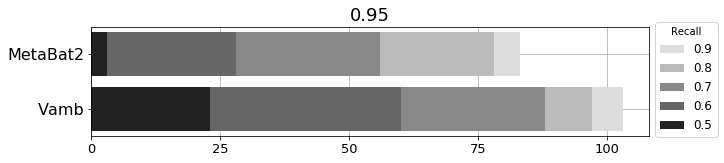

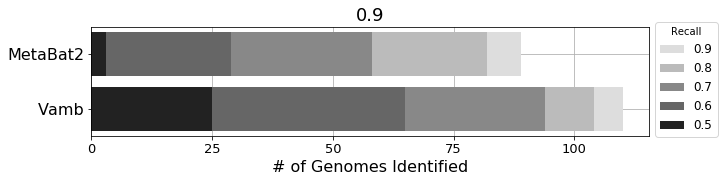

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load results from our run of Metabat2 on Metabat_errorfree dataset
with open('/mnt/computerome/projects/deep_bin/paper/metabat_on_metabat/observed.tsv') as file:
    obs_metabat = vamb.benchmark.Observed.fromfile(file, reference)
    
metabatresult = vamb.benchmark.BenchMarkResult(reference=reference, observed=obs_metabat)

for precision in 0.95, 0.9:

    plt.figure(figsize=(10, 2))
    colors = ['#DDDDDD', '#BBBBBB', '#888888', '#666666', '#222222']
    recalls = [0.5, 0.6, 0.7, 0.8, 0.9]
    for y, benchmark in zip((0, 1), (result, metabatresult)):
        for color, recall in zip(colors, recalls):
            plt.barh(y, benchmark[recall, precision], color=color)

    plt.title(str(precision), fontsize=18)
    plt.yticks([0, 1], ['Vamb', 'MetaBat2'], fontsize=16)
    plt.xticks([i*25 for i in range(5)], fontsize=13)
    plt.legend([str(i) for i in reversed(recalls)], bbox_to_anchor=(1, 1.1), title='Recall', fontsize=12)
    
    if precision == 0.9:
        plt.xlabel('# of Genomes Identified', fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.grid()